## Mount to Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Setup

In [31]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd

## Read the Yelp Dataset

In [32]:
df = pd.read_csv("/content/gdrive/MyDrive/train3.csv")
print((df['Class'] == 'positive').sum())
print((df['Class'] == 'negative').sum())
print((df['Class'] == 'neutral').sum())

38348
11897
5755


In [33]:
def convert_to_number(class_name):
  if class_name == "positive":
    return 1
  elif class_name == "neutral":
    return 0
  else:
    return 2

df['Class'] = df['Class'].map(convert_to_number)
print(df.shape)

(56000, 3)


## Remove Stop words, punctuation and Lemmatization

In [34]:
import string
import re
import nltk

nltk.download('stopwords')

def erase_punctuation(text):
  translator = str.maketrans("", "", string.punctuation)
  return text.translate(translator)

new_stopwords = []
with open('/content/gdrive/MyDrive/stop_words.lst') as f:
    for line in f:
      new_stopwords.append(line.strip())
print(new_stopwords)

from nltk.corpus import stopwords
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)
print(len(stpwrd))
# remove duplicate stop words
stopwords = set(stpwrd)
print(len(stopwords))

def remove_stop(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stopwords]
  return " ".join(filtered_words)

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()
def lemmatization(x):
  new_x = []
  for word in str(x).split():
    new_x.append(lemmatizer.lemmatize(word))
  return ' '.join(new_x)

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [35]:
df['Text'] = df['Text'].apply(lambda x: erase_punctuation(x))
df['Text'] = df['Text'].apply(lambda x: remove_stop(x))
df['Text'] = df['Text'].apply(lambda x: lemmatization(x))
df.head()

,Text,Class,ID
0,fun little place stop lunch plenty parking tab...,1,1307144
1,place packed went late night food serve late a...,2,5544361
2,board plane 30 minute actual flight make sure ...,1,5956200
3,chaotic 4 story place fun kid white chocolate ...,1,718388
4,intentionally capsizing sailboat ttl spent goo...,0,174754


## Split the data into training, testing, and validation sets

In [20]:
import sklearn
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# split text and labels
train_sentences = train_df['Text'].to_numpy()
train_labels = train_df['Class'].to_numpy()

val_sentences = val_df['Text'].to_numpy()
val_labels = val_df['Class'].to_numpy()


test_sentences = test_df['Text'].to_numpy()
test_labels = test_df['Class'].to_numpy()

df.head()

,Text,Class,ID
0,fun little place stop lunch plenty parking tab...,1,1307144
1,place packed went late night food serve late a...,2,5544361
2,board plane 30 minute actual flight make sure ...,1,5956200
3,chaotic 4 story place fun kid white chocolate ...,1,718388
4,intentionally capsizing sailboat ttl spent goo...,0,174754


In [36]:
print("Training entries: {}, test entries: {}".format(len(train_sentences), len(val_sentences)))

Training entries: 35840, test entries: 8960


In [22]:
train_sentences[:10]

array(['mike miller dj vow renewal mix age mike 17 year old dancing midnight music mike early helpful number technical aspect reception highly professional personable quite affordable',
       'usually pho fix home cause compare mama cooking eat pho restaurant say favorite place goto pho binh minh located 17th ave se avenue pho restaurant basically unlike lot place place us fresh pho noodle make remarkable difference taste broth right thinly sliced beef taste delicious forget dish available definitely try bun cha gio thit nuong vermecelli w beef spring roll rice dish taste great',
       'want wait line brunch eat long time suggest place far place truly nice hidden gem container park level recommend using street level access corner brunch mimosa breakfast skillet customize',
       'best new york style chinese food restaurant outside nyc chicken broccoli spot brown sauce flavor broccoli cooked slight crunchy perfection thought mention downtown dont pas restaurant disappointhave add fas

In [23]:
train_labels[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Make word embedding layer of NN

In [25]:
model = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_sentences[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.1384184 , -0.22871655, -0.34741542, -0.22721   , -0.30846748,
         0.00562858,  0.30742484, -0.24686453, -0.49522042,  0.2837874 ,
         0.11697393, -0.2378197 ,  0.31858838,  0.06282561,  0.06655555,
        -0.37064585, -0.15341   ,  0.05426222,  0.12385743, -0.271793  ,
        -0.20761234,  0.13651681, -0.2711912 ,  0.05846886, -0.13601542,
        -0.1357587 ,  0.14033708, -0.30586493,  0.37945795,  0.3067474 ,
        -0.00231218,  0.02300742,  0.18738551,  0.01606855,  0.16681473,
        -0.09897768,  0.2859028 ,  0.40903994, -0.01140193, -0.45000407,
         0.35537094,  0.38749295, -0.02733273, -0.03646052,  0.16973256,
         0.09952641, -0.08293172, -0.2325519 ,  0.7476069 ,  0.26440188],
       [ 0.54997563, -0.7822773 , -0.5996176 , -0.48389697, -0.23877111,
        -0.3377327 ,  0.40178594,  0.18064022, -0.79556066,  0.20132482,
         0.66166025, -0.40445918,  0.33204678,  0.06189556, -0.2704824 ,
 

## Build model

In [37]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 16)                816       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 48,191,579
Trainable params: 48,191,579
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [39]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Train the model

In [30]:
history = model.fit(train_sentences,
                    train_labels,
                    epochs=1000,
                    batch_size=512,
                    validation_data=(val_sentences, val_labels),
                    verbose=1,
                    callbacks=[es, model_checkpoint_callback])

Epoch 1/1000
70/70 [==============================] - 7s 69ms/step - loss: 0.9271 - accuracy: 0.5629 - val_loss: 0.7419 - val_accuracy: 0.6904
Epoch 2/1000
70/70 [==============================] - 5s 66ms/step - loss: 0.6333 - accuracy: 0.7609 - val_loss: 0.5048 - val_accuracy: 0.8273
Epoch 3/1000
70/70 [==============================] - 5s 66ms/step - loss: 0.4529 - accuracy: 0.8349 - val_loss: 0.4089 - val_accuracy: 0.8451
Epoch 4/1000
70/70 [==============================] - 5s 66ms/step - loss: 0.3686 - accuracy: 0.8618 - val_loss: 0.3905 - val_accuracy: 0.8484
Epoch 5/1000
70/70 [==============================] - 2s 33ms/step - loss: 0.3194 - accuracy: 0.8791 - val_loss: 0.3928 - val_accuracy: 0.8482
Epoch 6/1000
70/70 [==============================] - 2s 33ms/step - loss: 0.2862 - accuracy: 0.8937 - val_loss: 0.4045 - val_accuracy: 0.8463
Epoch 7/1000
70/70 [==============================] - 2s 34ms/step - loss: 0.2529 - accuracy: 0.9063 - val_loss: 0.4262 - val_accuracy: 0.8483

## Evaluate the model


In [ ]:
# The model weights (that are considered the best) are loaded into the
# model.
model.load_weights(checkpoint_filepath)

results = model.evaluate(test_sentences, test_labels)

print(results)

350/350 [==============================] - 2s 5ms/step - loss: 0.3665 - accuracy: 0.8652
[0.36653944849967957, 0.8651785850524902]


## Save the model

In [ ]:
model.save("/content/gdrive/MyDrive/my_model")

## Plot training and validation accuracy and loss over time



In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

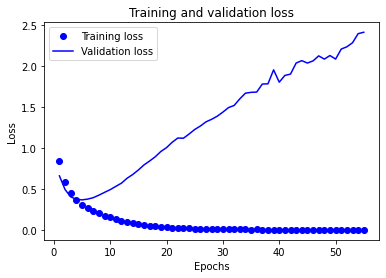

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

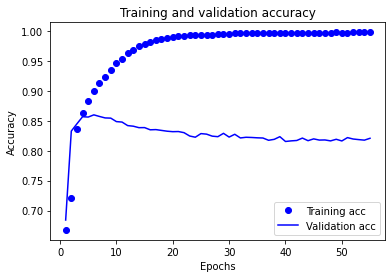

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Predict

In [ ]:
predictions_df = pd.read_csv('/content/gdrive/MyDrive/test3.csv')
predictions_df

,ID,Text
0,178,!:)I could pass out here and survive the zombi...
1,344,15% tips sneaked into our bill even though we ...
2,2324,How bad could it be? I thought After all its...
3,3217,Jordan is awesome! I have a lot of muscle tens...
4,3705,Micheals Arts and CraftsWell they live under ...
...,...,...
13995,6662447,wifi doesnt work Also even it works it is v...
13996,6662575,wish I could select zero stars This place wa...
13997,6664830,ya know this place is so good and so unassumi...
13998,6665591,you definitely dont want to bring a first date...


In [ ]:
predict_sentences = predictions_df['Text'].to_numpy()
predict_x = model.predict(predict_sentences) 
classes_x = np.argmax(predict_x,axis=1)
print(len(classes_x))

438/438 [==============================] - 2s 5ms/step
14000


In [ ]:
unique, counts = np.unique(classes_x, return_counts=True)
dict(zip(unique, counts))

{0: 864, 1: 10023, 2: 3113}

In [ ]:
predictions_df['CLASS'] = pd.Series(classes_x)
predictions_df

,ID,Text,CLASS
0,178,!:)I could pass out here and survive the zombi...,1
1,344,15% tips sneaked into our bill even though we ...,2
2,2324,How bad could it be? I thought After all its...,2
3,3217,Jordan is awesome! I have a lot of muscle tens...,1
4,3705,Micheals Arts and CraftsWell they live under ...,1
...,...,...,...
13995,6662447,wifi doesnt work Also even it works it is v...,2
13996,6662575,wish I could select zero stars This place wa...,2
13997,6664830,ya know this place is so good and so unassumi...,1
13998,6665591,you definitely dont want to bring a first date...,1


In [ ]:
def convert_num_to_class(val):
  if val == 1:
    return 'positive'
  elif val == 0:
    return 'neutral'
  else:
    return 'negative'
predictions_df['CLASS'] = predictions_df['CLASS'].map(convert_num_to_class)
predictions_df

,ID,Text,CLASS
0,178,!:)I could pass out here and survive the zombi...,positive
1,344,15% tips sneaked into our bill even though we ...,negative
2,2324,How bad could it be? I thought After all its...,negative
3,3217,Jordan is awesome! I have a lot of muscle tens...,positive
4,3705,Micheals Arts and CraftsWell they live under ...,positive
...,...,...,...
13995,6662447,wifi doesnt work Also even it works it is v...,negative
13996,6662575,wish I could select zero stars This place wa...,negative
13997,6664830,ya know this place is so good and so unassumi...,positive
13998,6665591,you definitely dont want to bring a first date...,positive


In [ ]:
predictions_df.rename({'ID': 'REVIEW-ID'}, axis=1, inplace=True)
predictions_df

,REVIEW-ID,Text,CLASS
0,178,!:)I could pass out here and survive the zombi...,positive
1,344,15% tips sneaked into our bill even though we ...,negative
2,2324,How bad could it be? I thought After all its...,negative
3,3217,Jordan is awesome! I have a lot of muscle tens...,positive
4,3705,Micheals Arts and CraftsWell they live under ...,positive
...,...,...,...
13995,6662447,wifi doesnt work Also even it works it is v...,negative
13996,6662575,wish I could select zero stars This place wa...,negative
13997,6664830,ya know this place is so good and so unassumi...,positive
13998,6665591,you definitely dont want to bring a first date...,positive


In [ ]:
# df.to_csv('result.csv',index=False)
header = ["REVIEW-ID", "CLASS"]
predictions_df.to_csv('/content/gdrive/MyDrive/prediction.csv', columns = header, index=False)